# Data Exploration

In [1]:
import codecs
import json
import os
import re
import pandas as pd
import numpy as np
#from pandasgui import show

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set_style('whitegrid')

Load axuilar functions that will be used when **cleaning the data**. Specially focused on detecting varieties synonyms as well just selecting the representatives varieties in *coupage* wines (wines made from different varieties).

In [2]:
import sys
sys.path.append(r'../utils//')
from utils import *

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

## Load and Clean data

Load all the *json* files previously obtained using a customized web scrapper and stored in a directory. Each file correspont a unique wine.

In this part we'll also use a function to detect varieties synonyms and only use one to simplify the future training process. The varieties synonyms dictionary can be found in *'../Cleaner/unique_varieities.xlsx'*

We will also use a function to reduce the amount of varieties in the *coupage* wines. This function will remove the varieity in the wine if this one **represents less than 15% of the total**. This treshold has been set after reading [Minimum percentage of main variety in blends for legal labelling. A sensory perspective](https://www.bio-conferences.org/articles/bioconf/abs/2019/01/bioconf-oiv2018_03023/bioconf-oiv2018_03023.html)

In [3]:
all_wines = []


WINE_INFO_DIRECTORY = r'../Scrapper/wine_data_raw'
SYNONYMS_PATH=r'../Cleaner/unique_varieities.xlsx'

# Create the synonims dics mapping
varieity_map_path = create_variety_synonyms_dictonary(SYNONYMS_PATH)

for filename in os.listdir(WINE_INFO_DIRECTORY):
    fh = codecs.open(f'{WINE_INFO_DIRECTORY}/{filename}','r','utf-8')
    wd = json.load(fh)
    fh.close()

    # Clean variety if it exist
    if "variedades" in wd.keys():
        cleaned_varieties =[]
        for variety in wd["variedades"]:
            var_clean = clean_variety(variety, varieity_map_path, min_per=15)
            if var_clean is not None:
                cleaned_varieties.append(var_clean)
        
        wd["variedades"] = cleaned_varieties

    # As wine type is always equal to one let's change the type from list to object
    wd["tipo"]= wd["tipo"][0]

    # Get Wine ID
    wd["id"] = filename.replace(".json","")

    
    all_wines += [wd,]


In [4]:
print(f"We found: {len(all_wines)} different wines")
print(all_wines[0])

We found: 4151 different wines
{'name': '10000 Hores Floral 2019', 'points': '87', 'tipo': 'blanco', 'variedades': ['moscatel de frontignan', 'sauvignon blanc'], 'bodega': 'Oliver Viticultors', 'zona de producción': 'Penedès  D.O.  / D.O.P.', 'país': 'España', 'fecha de cata': '28-01-2020', 'ecologic': True, 'estilo': ['fresco', 'frutal', 'herbal', 'sencillo'], 'price': 7.5, 'id': '10000_hores_floral_2019_b'}


We can see that we've found **4151 different wines**. Let's convert them into a DataFarme:

In [5]:
df = pd.DataFrame(all_wines)
df.head()

,name,points,tipo,variedades,bodega,zona de producción,país,fecha de cata,ecologic,estilo,price,id,boca,color,aroma
0,10000 Hores Floral 2019,87,blanco,"[moscatel de frontignan, sauvignon blanc]",Oliver Viticultors,Penedès D.O. / D.O.P.,España,28-01-2020,True,"[fresco, frutal, herbal, sencillo]",7.5,10000_hores_floral_2019_b,NaN,NaN,NaN
1,10000 Hores Floral 2020,87,blanco,"[moscatel de frontignan, sauvignon blanc]",Oliver Viticultors,Penedès D.O. / D.O.P.,España,NaN,True,"[aromático, floral, suave, sencillo]",7.5,10000_hores_floral_2020_b,NaN,NaN,NaN
2,10000 Hores Negre Selecció 2018,88,tinto,"[tempranillo, syrah]",Oliver Viticultors,Penedès D.O. / D.O.P.,España,28-01-2020,True,"[aromático, frutal, maduro, floral, herbal, ag...",7.0,10000_hores_negre_seleccio_2018_t,NaN,NaN,NaN
3,10000 Hores Negre Selecció 2019,89,tinto,"[tempranillo, syrah]",Oliver Viticultors,Penedès D.O. / D.O.P.,España,NaN,True,"[amable, balsámico, corpulento, maduro, sabros...",7.0,10000_hores_negre_seleccio_2019_t,NaN,NaN,NaN
4,10000 Hores Rosé 2019,87,rosado,"[merlot, tempranillo]",Oliver Viticultors,Penedès D.O. / D.O.P.,España,28-01-2020,True,"[sencillo, fresco, herbal, floral]",7.0,10000_hores_rose_2019_rd,NaN,NaN,NaN


## Name

We can see that all wines have the harvest year in their name so we can see that *10000 Hores Floral 2019* and the *10000 Hores Floral 2020* are the same wine but was produced in two different years. 

First of all, let us create a new variable that will extract the year:

In [6]:
df["year"] = df.name.str.extract(r"(\b20\d{2}\b)")

In [7]:
df[["name","year"]].head(10)

,name,year
0,10000 Hores Floral 2019,2019
1,10000 Hores Floral 2020,2020
2,10000 Hores Negre Selecció 2018,2018
3,10000 Hores Negre Selecció 2019,2019
4,10000 Hores Rosé 2019,2019
5,10000 Hores Rosé 2020,2020
6,10000 Hores Xarel.lo 2020,2020
7,125 de Celler Sanromà 2016 Barrica,2016
8,125 de Celler Sanromà 2017 Barrica,2017
9,125 de Celler Sanromà 2018 Barrica,2018


We can see in the above table that in our data we can have different harvest years of the same wine. As one of the our objectives is to create a **content based recommender** (due to lack of user data) we suspect that this recommender will find that the most similar wine is the same wine but from a different year.

In order to avoid this to happen we plan to **keep only the most recent wine**, but we need to quantify how many observations we loose:


First let us extract the year from the full name:

In [8]:
df["name_no_year"] = df.name.str.replace(r"\s?\b20\d{2}\b\s?","",regex=True)

In [20]:
df[["name","name_no_year","year"]].iloc[300:310]

,name,name_no_year,year
300,Armero Adrover Rosat 2019,Armero Adrover Rosat,2019
301,Armero i Adrover Callet Selecció Familiar 2017,Armero i Adrover Callet Selecció Familiar,2017
302,Arnau de Rendé Masdeu 2016 Crianza Seco,Arnau de Rendé MasdeuCrianza Seco,2016
303,Arnau de Rendé Masdeu 2018 Crianza Seco,Arnau de Rendé MasdeuCrianza Seco,2018
304,Arnau Oller 2016 Reserva,Arnau OllerReserva,2016
305,Aroa 2017,Aroa,2017
306,Aroa 2018,Aroa,2018
307,Ars Collecta 457 2008 Gran Reserva Brut,Ars Collecta 457Gran Reserva Brut,2008
308,Ars Collecta 459 2010 Gran Reserva Brut,Ars Collecta 459Gran Reserva Brut,2010
309,Ars Collecta Blanc de Blancs 2015 Gran Reserva...,Ars Collecta Blanc de BlancsGran Reserva Brut,2015


Now that we have exctacted the wine harvest year, let's investigate if there is common to have duplicates:

In [21]:
df.groupby(["name_no_year"])["name_no_year"].count().reset_index(name="count_duplicates").groupby(["count_duplicates"])["count_duplicates"].count().reset_index(name="WinesNumber")

,count_duplicates,WinesNumber
0,1,1942
1,2,982
2,3,43
3,4,24
4,5,4


We have 1942 unique wine observations and 982 that we have 2 observations, 43 that have 3 wines,etc. 

Overall we'll remove 1.156 observations with that decision. 

In [22]:
df.groupby(["name_no_year"])["name_no_year"].count().reset_index(name="count_duplicates")\
.groupby(["count_duplicates"])["count_duplicates"].count().reset_index(name="WinesNumber").WinesNumber.sum()

2995

In this step will drop wine duplicates and keep only the one from the most reccent year

In [23]:
df = df.sort_values(by="year",ascending=False).drop_duplicates(subset=["name_no_year"])
df.head(5)

,name,points,tipo,variedades,bodega,zona de producción,país,fecha de cata,ecologic,estilo,price,id,boca,color,aroma,year,name_no_year
3490,Serra de Cavalls Garnacha Blanca 2021,86,blanco,[garnacha blanca],Serra de Cavalls,Terra Alta D.O. / D.O.P.,España,NaN,False,"[correcto, frutal, herbal]",5.80,serra_de_cavalls_garnacha_blanca_2021_b,NaN,NaN,NaN,2021,Serra de Cavalls Garnacha Blanca
601,Cala Marquesa 2020,88,blanco,[garnacha blanca],Alegre Wines & Spirits,Empordà D.O. / D.O.P.,España,NaN,False,"[maduro, sabroso, goloso, flores secas]",8.40,cala_marquesa_2020_b,NaN,NaN,NaN,2020,Cala Marquesa
3076,Pocapena 2020,85,tinto,"[tempranillo, garnacha]",Carviresa Cellers,Costers del Segre D.O. / D.O.P.,España,NaN,False,"[sencillo, suave, frutal, maduro]",4.84,pocapena_2020_t,NaN,NaN,NaN,2020,Pocapena
456,Binifadet 2020,91,blanco,NaN,Bodegas Binifadet,Illa de Menorca Vino de la Tierra / I.G.P.,España,NaN,False,NaN,NaN,binifadet_2020_b,"[fresco, frutoso, buena acidez, fino amargor, ...",[pajizo brillante],"[fruta fresca, cítricos, hierbas silvestres]",2020,Binifadet
2065,La Picossa Garnacha Tinta 2020,89,tinto,[garnacha],Vins de Relat,Terra Alta D.O. / D.O.P.,España,NaN,False,"[especiado, frutal, maduro, tostado, sabroso]",7.00,la_picossa_garnacha_tinta_2020_t,NaN,NaN,NaN,2020,La Picossa Garnacha Tinta


## Points

Let's see the point distribution:

In [24]:
df.points = df.points.astype(float)
df.points.isna().sum()

0

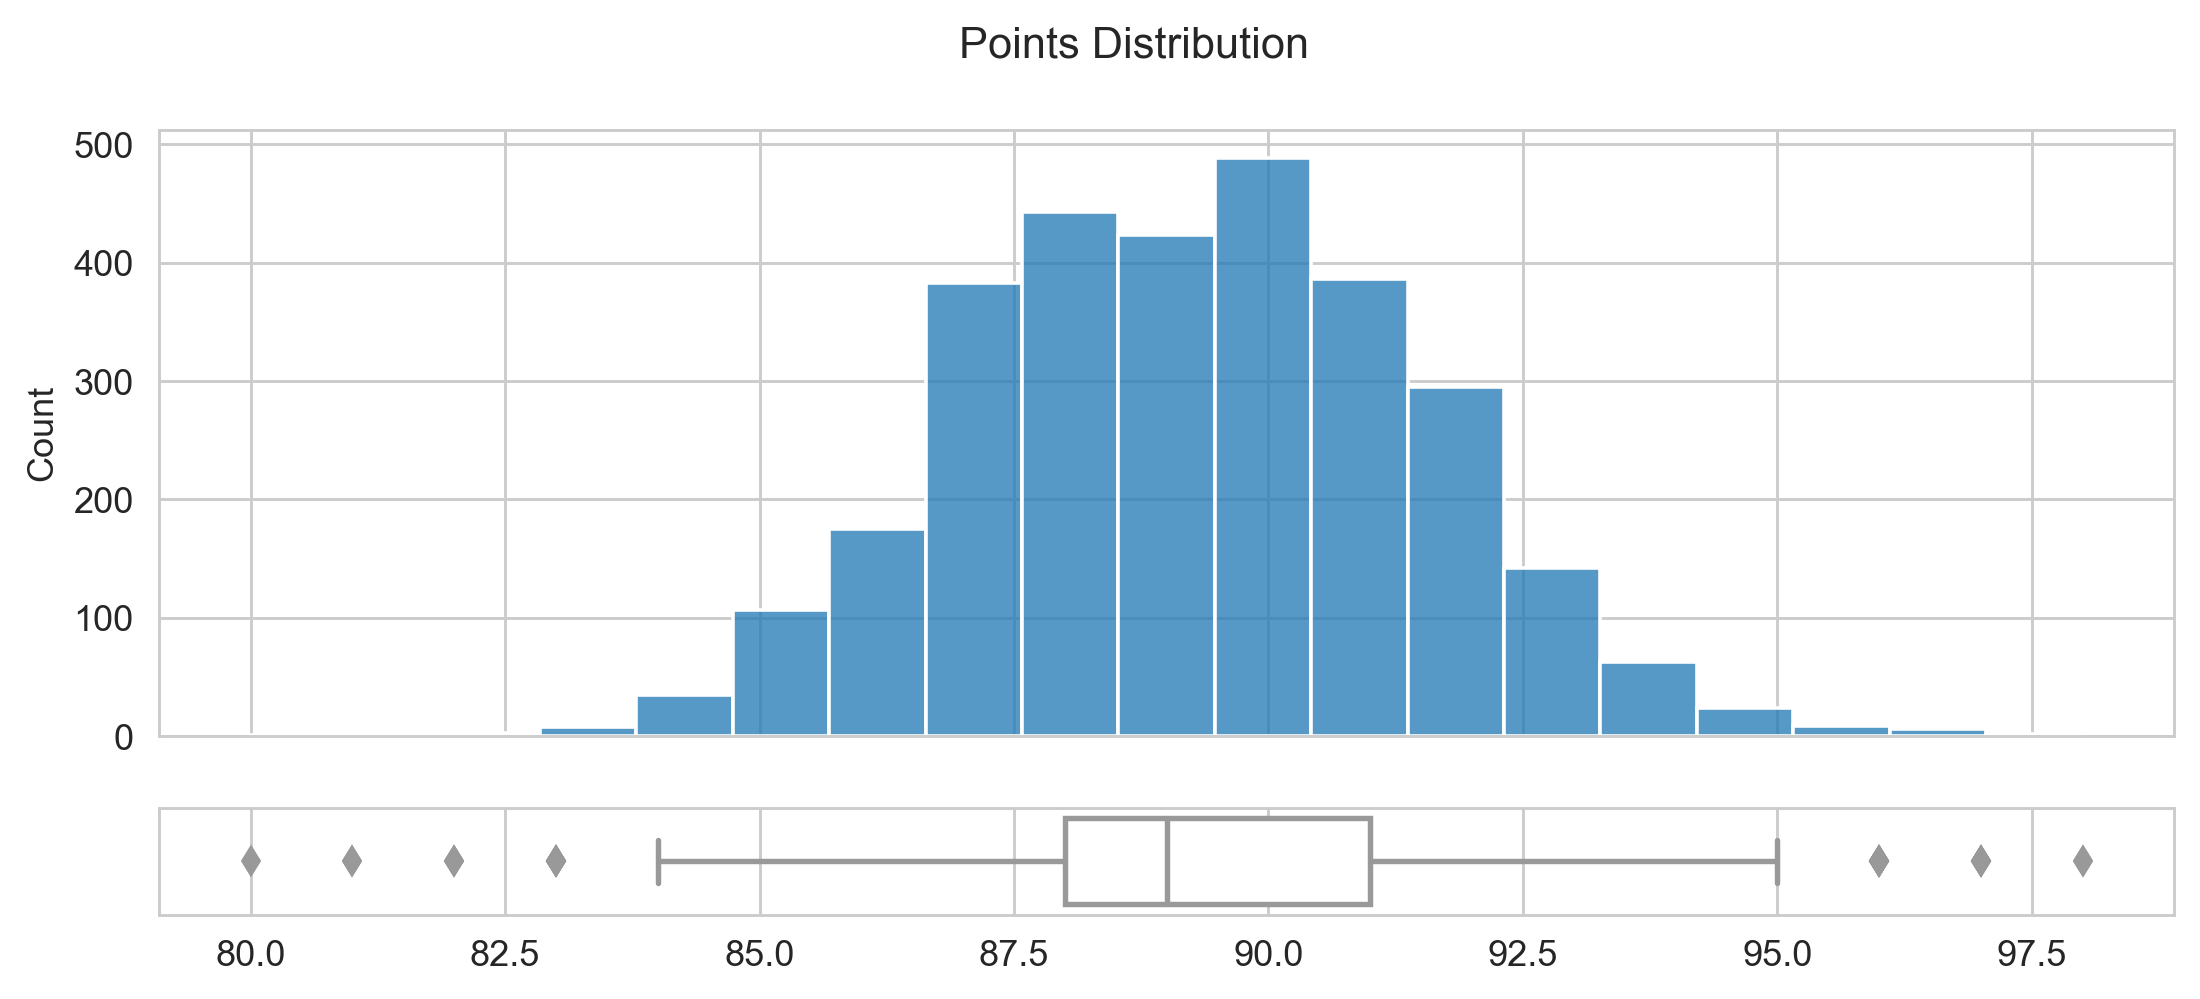

In [25]:
# creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_hist,ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.85, .15)},figsize=(10,4),dpi=130)
 
# assigning a graph to each ax
sns.boxplot(x=df["points"], ax=ax_box,color='white')
sns.histplot(data=df, x="points", ax=ax_hist,bins=19)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
f.suptitle("Points Distribution");
f.savefig("figs/points_distribution.png")

It's really interesting to see that all the wines have an score. The mean is arround 89 and we can say that most of the wines are between 87-91. Therfore we should supose that a **wine below 87 is a really bad wine**.

In [26]:
df.points.quantile(.5)

89.0

In [27]:
df.points.quantile(.75)

91.0

## Tipo

We have a lot of different type of wines:

In [28]:
df.tipo.nunique()

97

If we plot the wine count per each type we can see that the blanco,tinto, tinto crianza and then the sparkling are the majority:

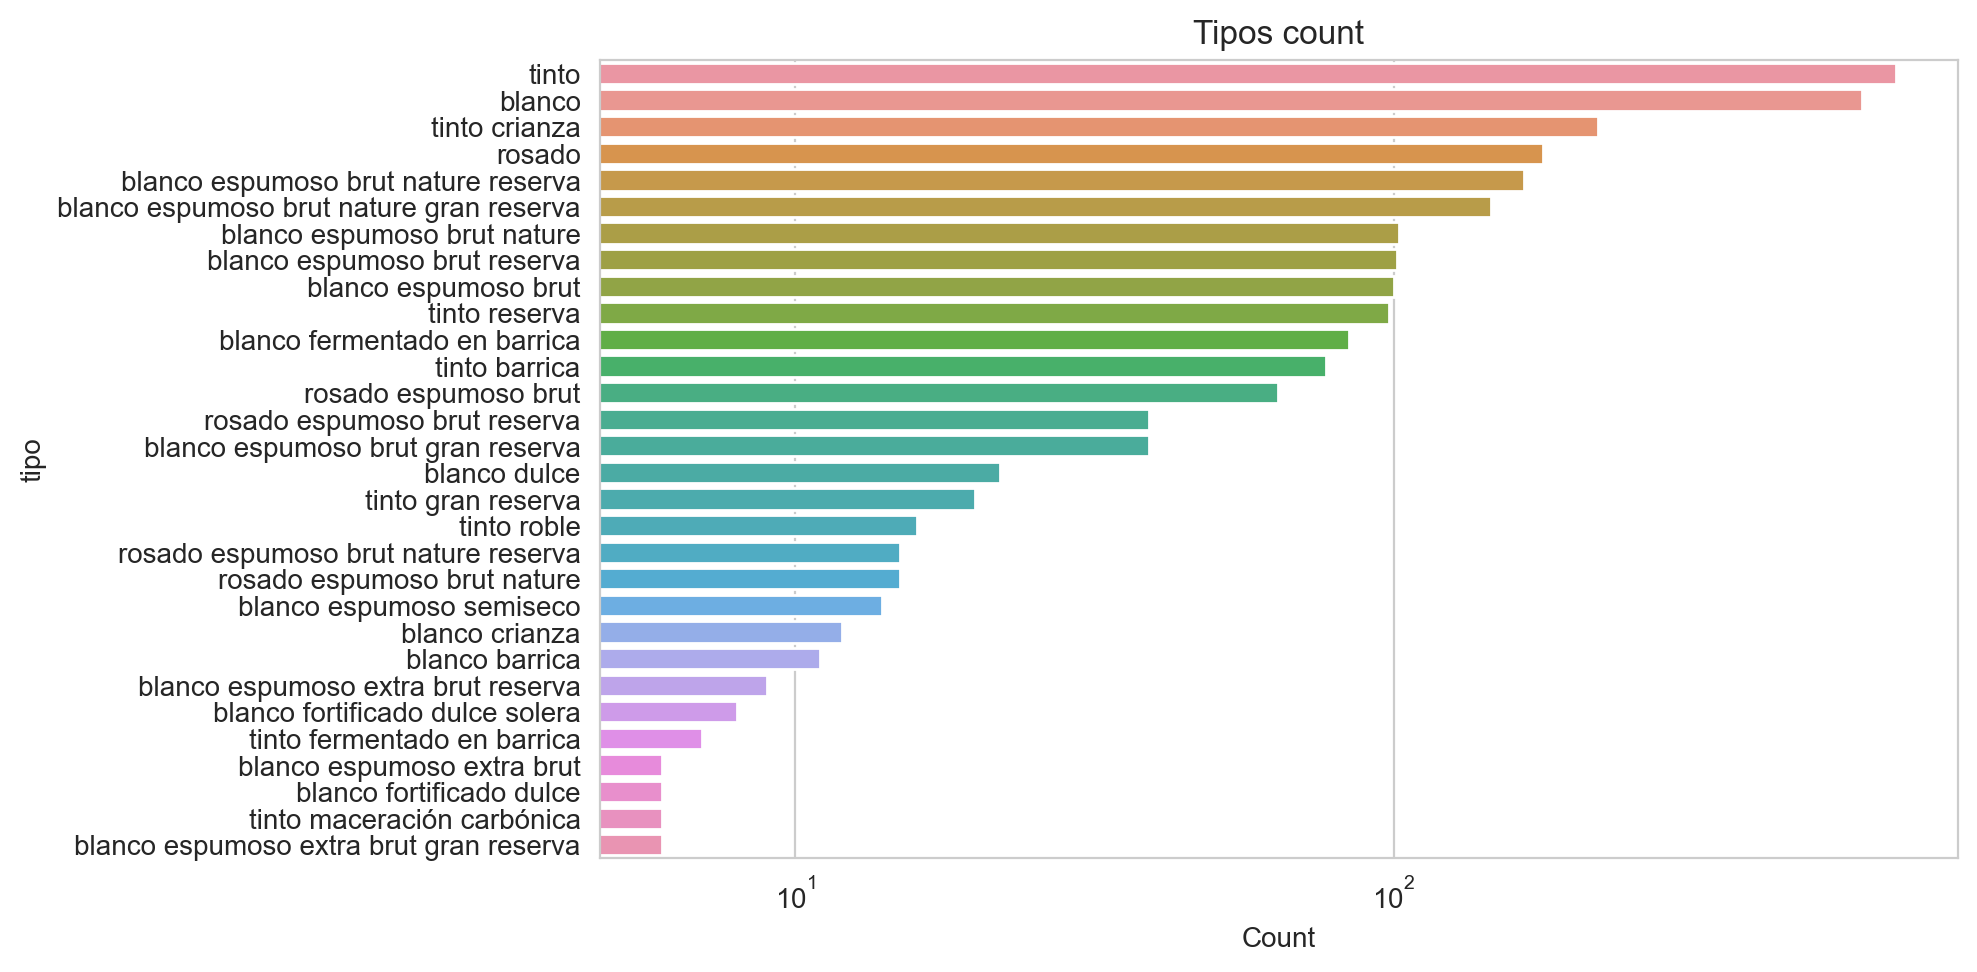

In [29]:
plt.figure(figsize=(10,5),dpi=100)

count_types = df.groupby(["tipo"])["tipo"].count().reset_index(name="Count").sort_values(by="Count",ascending=False)

g = sns.barplot(data=count_types[0:30], 
            x="Count",
            y="tipo"
            );
g.set_xscale("log")

plt.title("Tipos count");
plt.tight_layout()
plt.savefig("figs/wine_types_30.png")

We can get only the most common ones, for example we can get as many types as needed to cover up to 95% of the cases (applying Pareto's rule):

In [30]:
df_tipos = df.groupby(["tipo"])["name"].count().reset_index().rename(columns={"name":"count"}).sort_values(by="count",ascending=False)
df_tipos['percent'] = (df_tipos['count'] / df_tipos['count'].sum()) * 100
df_tipos['percent_cumsum'] = df_tipos.percent.cumsum()
feat_tipos = df_tipos[df_tipos.percent_cumsum<=95].tipo.unique()

We can see here that we started with 97 types and we ended with only 25 covering 95% percent of the cases:

In [31]:
print(df_tipos.tipo.nunique())
print(len(feat_tipos))

97
25


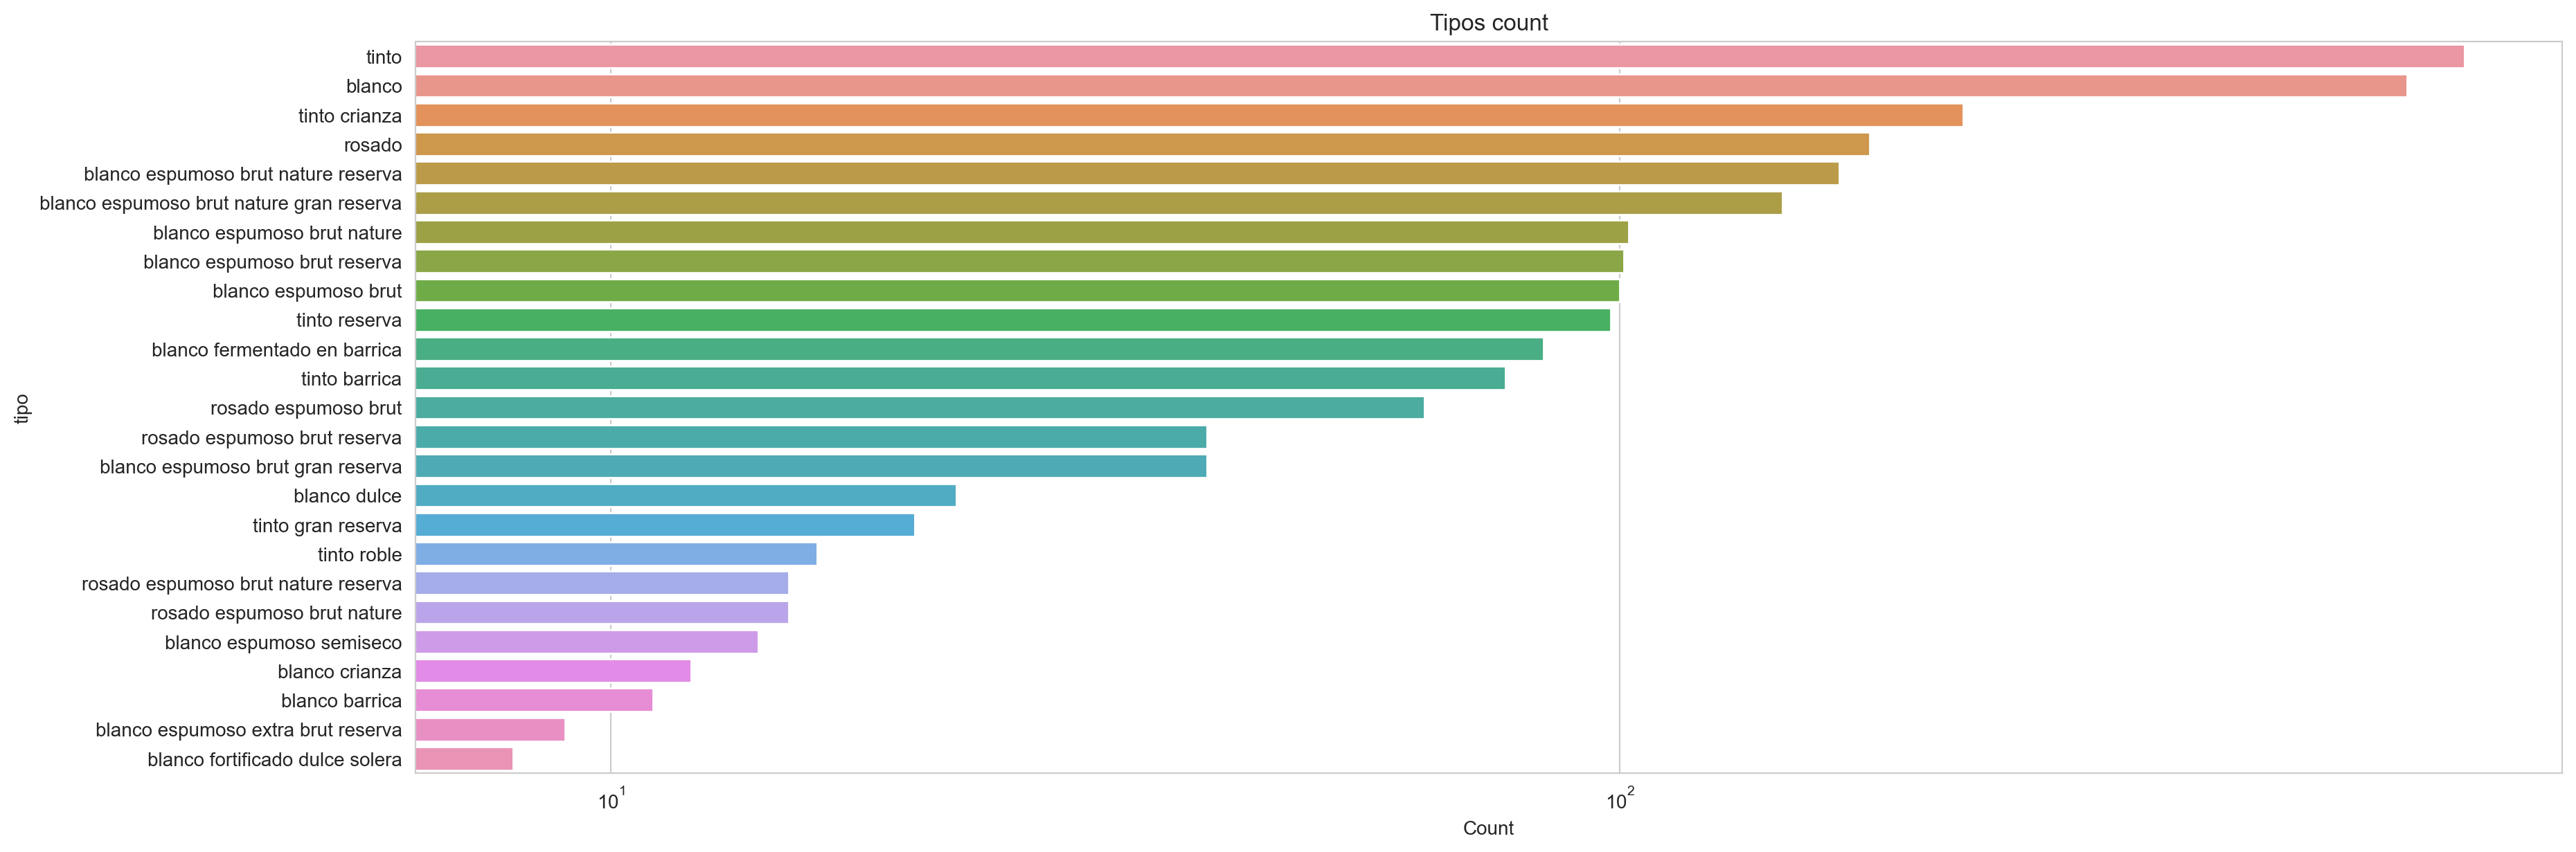

In [32]:
plt.figure(figsize=(20,7),dpi=100)

count_types = df.groupby(["tipo"])["tipo"].count().reset_index(name="Count").sort_values(by="Count",ascending=False)

g = sns.barplot(data=count_types[count_types.tipo.isin(feat_tipos)], 
            x="Count",
            y="tipo"
            );
g.set_xscale("log")

plt.title("Tipos count");

Still this will be difficult for people that are not experts in wine, as usually people only know about:
- tinto
- blanco
- espumoso
- rosado

Therefore, let's try to **convert all of the wines in these four categories**. This convertion will mean that we won't lose any observation in this step as all the wines will have in the type name one of the four above mentioned attributes. 

In [33]:
df["tipo_simplified"] = None

# Get the simplified type, caution the order is important!!!
df.loc[df.tipo.str.contains("tinto"),"tipo_simplified"] = "tinto"
df.loc[df.tipo.str.contains("blanco"),"tipo_simplified"] = "blanco"
df.loc[df.tipo.str.contains("espumoso"),"tipo_simplified"] = "espumoso"
df.loc[df.tipo.str.contains("rosado"),"tipo_simplified"] = "rosado"

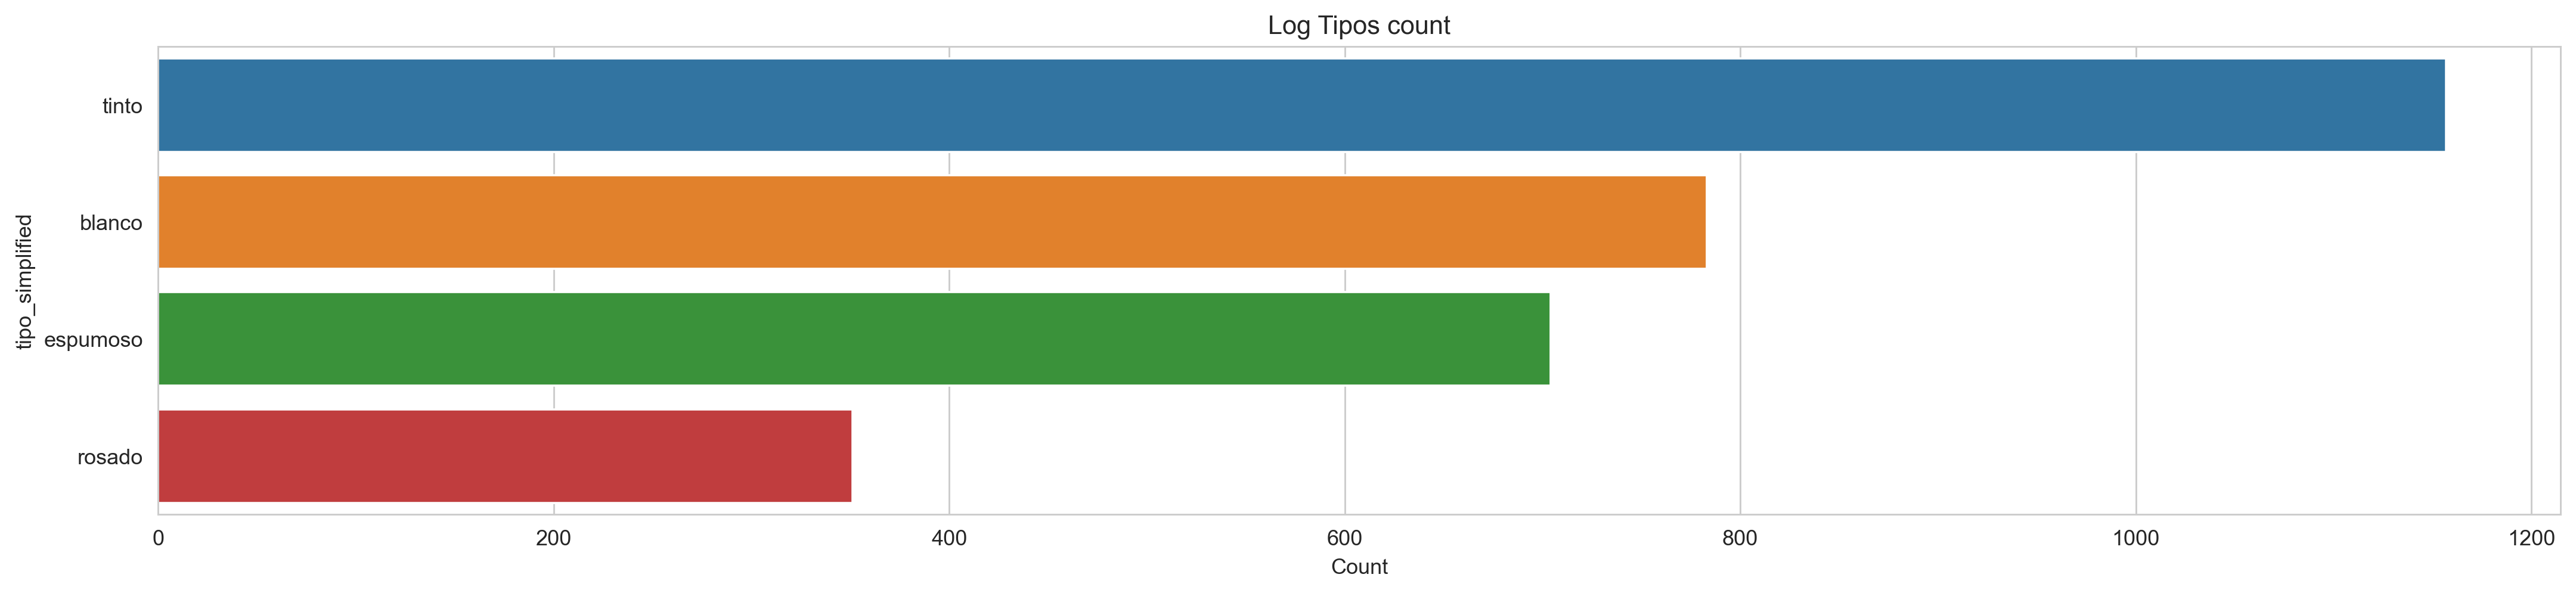

In [34]:
plt.figure(figsize=(20,4),dpi=130)

count_types = df.groupby(["tipo_simplified"])["tipo_simplified"].count().reset_index(name="Count").sort_values(by="Count",ascending=False)
g = sns.barplot(data=count_types, 
            x="Count",
            y="tipo_simplified"
            );
plt.title("Log Tipos count");

In [35]:
feat_tipo = df.tipo_simplified.unique()
feat_tipo

array(['blanco', 'tinto', 'espumoso', 'rosado'], dtype=object)

## Zone

There are 22 different DO:

In [36]:
df["zona de producción"].nunique()

22

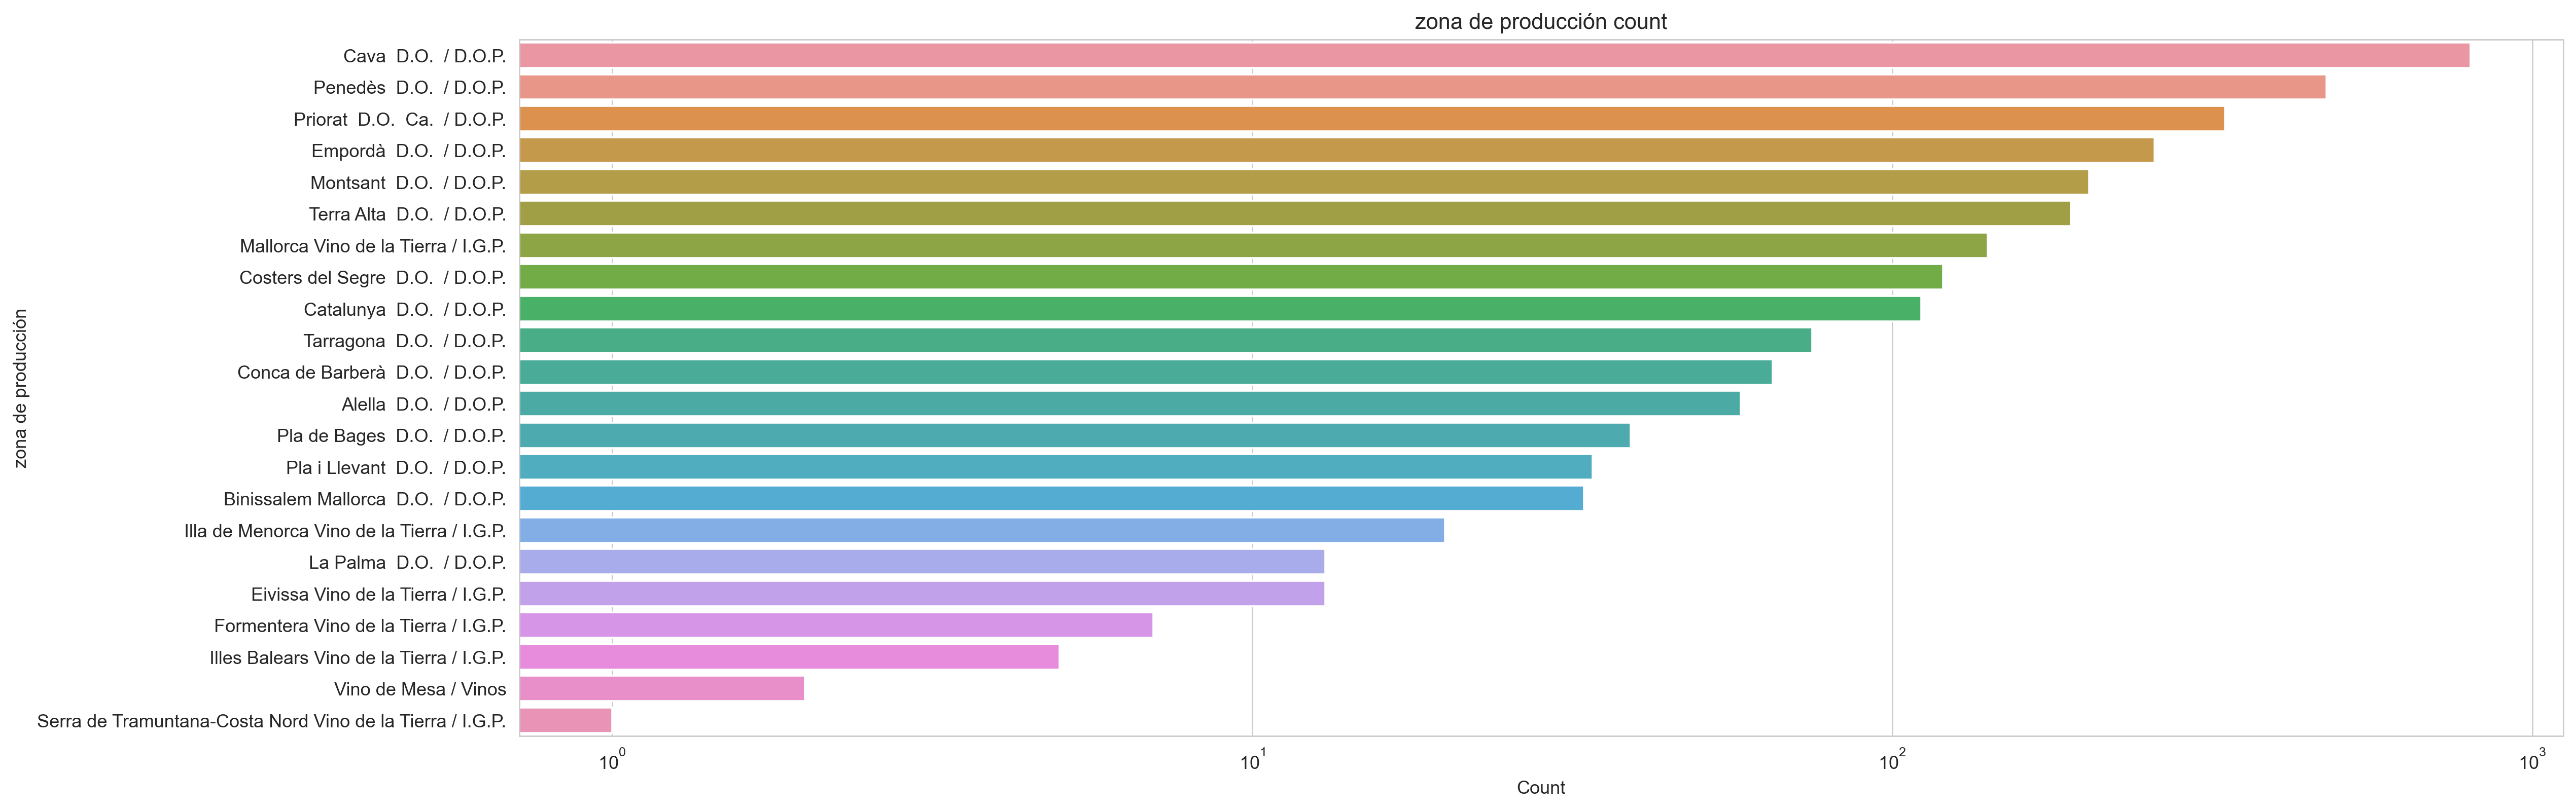

In [37]:
plt.figure(figsize=(20,7),dpi=130)

count_types = df.groupby(["zona de producción"])["zona de producción"].count().reset_index(name="Count").sort_values(by="Count",ascending=False)

g = sns.barplot(data=count_types, 
            x="Count",
            y="zona de producción"
            );
g.set_xscale("log")

plt.title("zona de producción count");

We observe that one of the production zones is *"Vinos de Mesa / Vinos"*. These wines do not have a specific DO.

One of the goals of this project is to recommend quality wines from Catalan speaking territory and we have observed that we have only few samples from the wines that are not made in Catalunya mainland. Therfore, in order to simplify this project we decided **only to select wines from the 12 Catalunya Mainland D.O./D.O.Q.**

In [38]:
feat_zona = [
       'Cava  D.O.  / D.O.P.',
       'Terra Alta  D.O.  / D.O.P.', 
       'Costers del Segre  D.O.  / D.O.P.',
       'Conca de Barberà  D.O.  / D.O.P.',
       'Priorat  D.O.  Ca.  / D.O.P.', 
       'Tarragona  D.O.  / D.O.P.',
       'Penedès  D.O.  / D.O.P.',
       'Empordà  D.O.  / D.O.P.',
       'Catalunya  D.O.  / D.O.P.',
       'Alella  D.O.  / D.O.P.',
       'Montsant  D.O.  / D.O.P.',
       'Pla de Bages  D.O.  / D.O.P.'

]

With that decision we are still **keeping the 90% of the wines**:

In [39]:
df["bool_zona_simplified"] = df["zona de producción"].isin(feat_zona)

In [40]:
df["bool_zona_simplified"].mean()

0.9101836393989984

In [41]:
# selecting only the Catalunya MainLand Zones
print(f"Unique wine observations with all the DO: {len(df)}")
df = df[df["bool_zona_simplified"]== True]
print(f"Unique wine observations with only Catalonia Mainland DO: {len(df)}")

Unique wine observations with all the DO: 2995
Unique wine observations with only Catalonia Mainland DO: 2726


In [42]:
df.head()

,name,points,tipo,variedades,bodega,zona de producción,país,fecha de cata,ecologic,estilo,price,id,boca,color,aroma,year,name_no_year,tipo_simplified,bool_zona_simplified
3490,Serra de Cavalls Garnacha Blanca 2021,86.0,blanco,[garnacha blanca],Serra de Cavalls,Terra Alta D.O. / D.O.P.,España,NaN,False,"[correcto, frutal, herbal]",5.80,serra_de_cavalls_garnacha_blanca_2021_b,NaN,NaN,NaN,2021,Serra de Cavalls Garnacha Blanca,blanco,True
601,Cala Marquesa 2020,88.0,blanco,[garnacha blanca],Alegre Wines & Spirits,Empordà D.O. / D.O.P.,España,NaN,False,"[maduro, sabroso, goloso, flores secas]",8.40,cala_marquesa_2020_b,NaN,NaN,NaN,2020,Cala Marquesa,blanco,True
3076,Pocapena 2020,85.0,tinto,"[tempranillo, garnacha]",Carviresa Cellers,Costers del Segre D.O. / D.O.P.,España,NaN,False,"[sencillo, suave, frutal, maduro]",4.84,pocapena_2020_t,NaN,NaN,NaN,2020,Pocapena,tinto,True
2065,La Picossa Garnacha Tinta 2020,89.0,tinto,[garnacha],Vins de Relat,Terra Alta D.O. / D.O.P.,España,NaN,False,"[especiado, frutal, maduro, tostado, sabroso]",7.00,la_picossa_garnacha_tinta_2020_t,NaN,NaN,NaN,2020,La Picossa Garnacha Tinta,tinto,True
3090,Portell Agulla Blanc 2020 Aguja,85.0,blanco espumoso aguja,"[macabeo, parellada]",Vinícola Sarral i Secció de Crèdit,Conca de Barberà D.O. / D.O.P.,España,NaN,False,"[tropical, golosinas, amable, aromático, senci...",5.35,portell_agulla_blanc_2020_be_ag,NaN,NaN,NaN,2020,Portell Agulla BlancAguja,espumoso,True


The wine observations after doing this data cleaning will be the one shown in the web App so before doing anything else we save it:

In [43]:
# Save the data before the OneHotEncodings for web
df.to_excel("wine_web_data.xlsx",index=False)

## Data Quality : Estilo / Boca / Color / Aroma

We can see that the number of different possible ways to describe wine from its taste,color and smell is unmanageable for most people that are not experts in the field.

Our proposal will be to reduce the number of different attributes for each way to define *color, smell and variety* while keeping the most used ones and therefore, the ones that most people will understand.

**Taste** and **Style** will be handled in a different manner as will be used to **predict the DO**

For example let's reduce the number of varieties but making sure that the remaining ones will cover **95%** of the cases:

### Variety

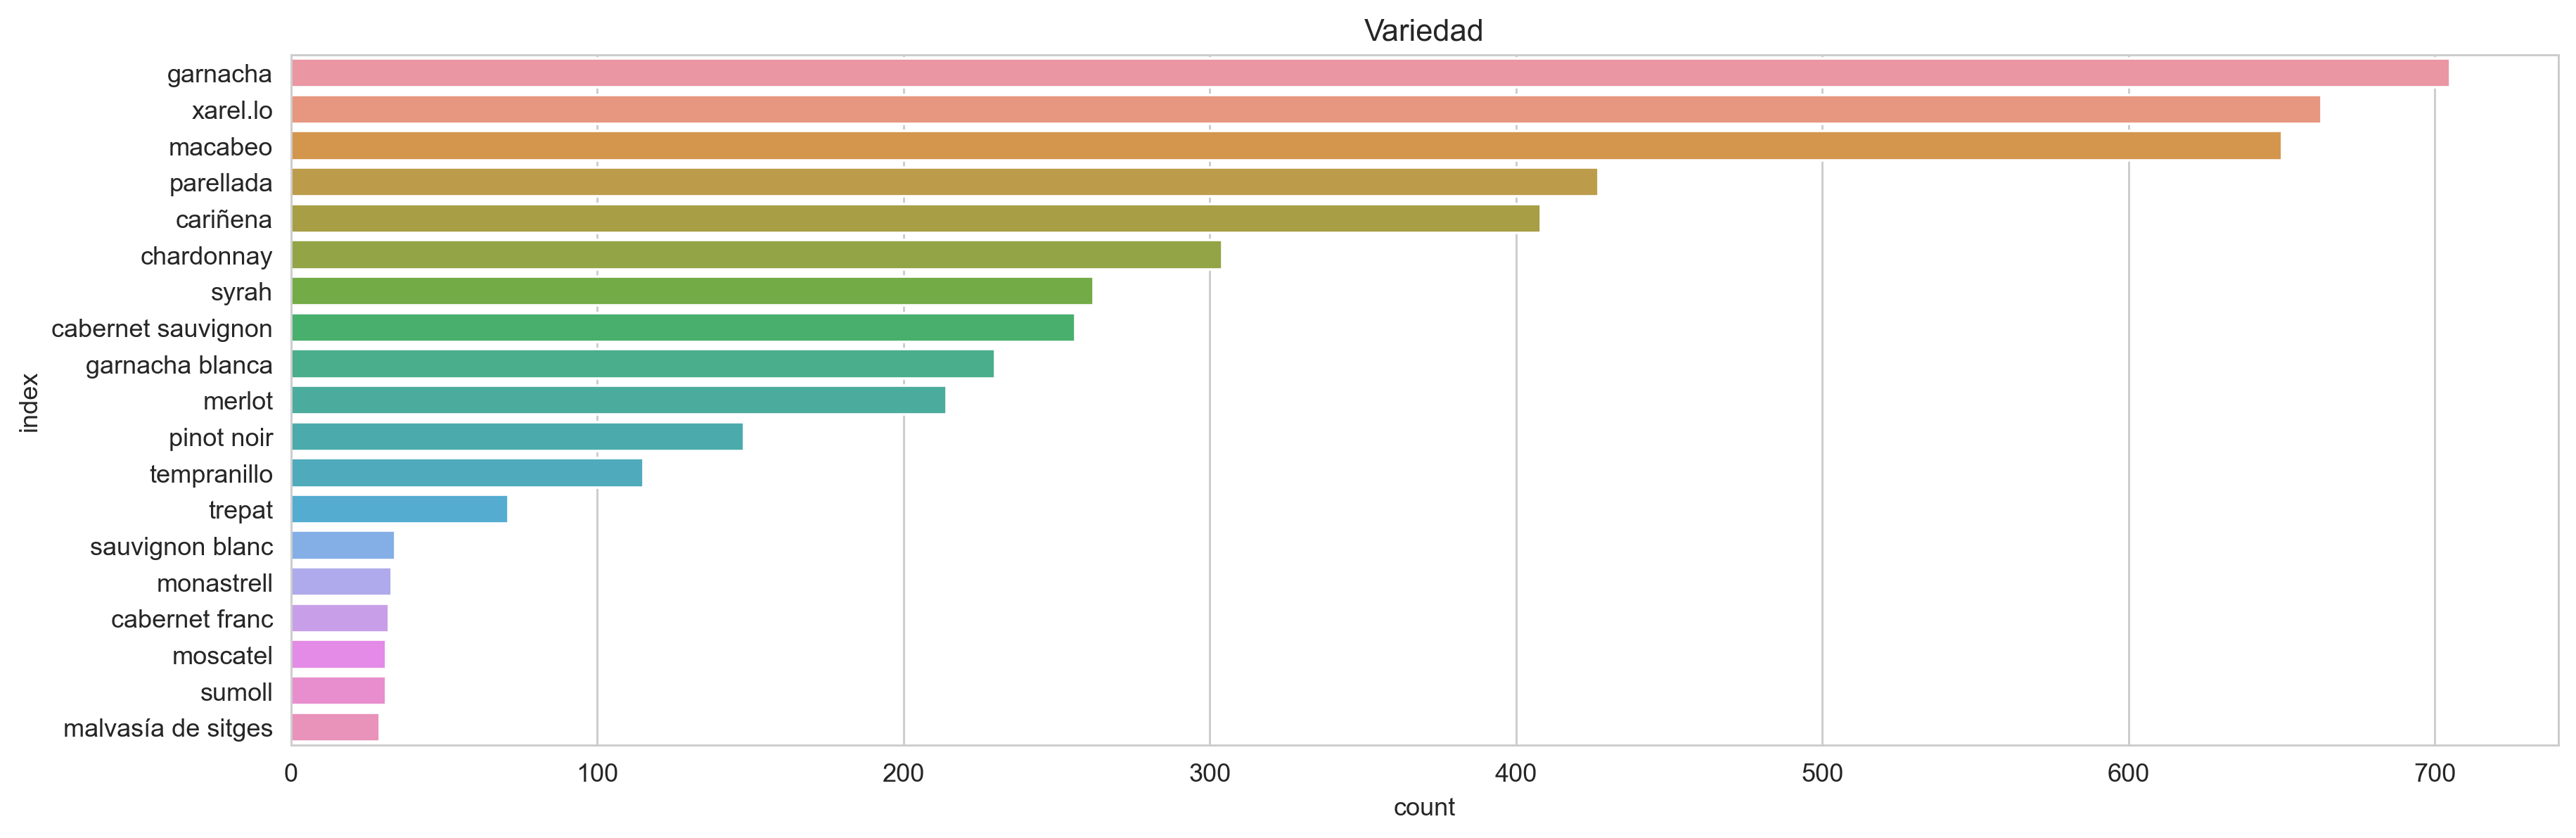

In [44]:
n_start_variedades,n_end_variedades,feat_variedades = barplot_wine_aspect(df.variedades, 'Variedad', 95,plot=True,orient="h")

As it can be seen we can **dramatically reduce the number of different varieties** while covering the 85% of the cases.

In [45]:
print(f"We start having {n_start_variedades} varieties that we have reduced up to {n_end_variedades}")

We start having 52 varieties that we have reduced up to 19


### Style and Taste

The style attribute is key as **we want to build an algorithm that will predict DO based on the style** but we have detected that we only have the style of:

In [46]:
df.estilo.notna().sum()

1671

But we always have either estilo or boca,color,aroma:


In [47]:
print(f"Wines in current df:             {len(df)} ")
print(f"Wines that have style or boca:   {len(df[(df.estilo.notna())|(df.boca.notna())])}")

Wines in current df:             2726 
Wines that have style or boca:   2726


Based on our personal experience boca determines quite well the style, let's try to merge them:

In [48]:
def combine_arrays(row):
    if not isinstance(row["estilo"],list):
        return row["boca"]
    elif not isinstance(row["boca"],list):
        return row["estilo"]
    else:
        return row["estilo"] + row["boca"]

In [49]:
df["new_estilo"] = df.apply(combine_arrays,axis=1)

In [50]:
# Get all the different style
n_start_estilo,n_end_estilo,feat_estilo = barplot_wine_aspect(df.new_estilo, 'Estilos',100,save_excel=False,plot=False)
pd.Series(feat_estilo).to_excel("dict4.xlsx")

We can notice in the previous graph that some of the atributes for non expert people looks really similar, for example *herbal* vs *herbáceo*. As this is an important atribute let's try to **sumarize them** based on our experience:

In [51]:
similar_styles = pd.read_excel("dict3_v2.xlsx")
list_synonyms=[]
for main_style in similar_styles.columns:
    list_synonyms.append([main_style,*similar_styles[main_style].dropna().values])
similar_styles.head()

,sabroso,especiado,frutal,equilibrado,herbal,cítrico,fresco,floral,correcto,tostado,...,con vejez,tropical,amargo,varietal,clásico,mineral,rústico,cremoso,carnoso,con defectos
0,NaN,NaN,frutoso,estructurado,vegetal,buena acidez,NaN,flores secas,NaN,retronasal ahumado,...,NaN,NaN,amargoso,NaN,crianza clásica,toques salinos,NaN,NaN,NaN,sin personalidad
1,NaN,NaN,retronasal afrutado,NaN,herbáceo,ácido,NaN,NaN,NaN,ahumado,...,NaN,NaN,fino amargor,NaN,NaN,salino,NaN,NaN,NaN,falta de equilibrio
2,NaN,NaN,NaN,NaN,hierbas secas,asidrado,NaN,NaN,NaN,muy tostado (torrefactado),...,NaN,NaN,astringente,NaN,NaN,NaN,NaN,NaN,NaN,oxidado
3,NaN,NaN,NaN,NaN,NaN,acidez marcada,NaN,NaN,NaN,retronasal torrefactado,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no representativo
4,NaN,NaN,NaN,NaN,NaN,con poca acidez,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,algo caído


For example, we have joined *floral* and *flores secas* or *potente* with *corpulento* in order to reduce the complexity when chosing a style.
Let's crearte a new column based on this:

In [52]:
from itertools import chain
new_column= []
for row in df.new_estilo.values:
    output_row=[]
    if type(row)==list:
        for style in row:
            if style in list(chain(*list_synonyms)):
                for styles in list_synonyms:
                    if style in styles and styles[0] not in output_row:
                        output_row.append(styles[0])
                        break
    if len(output_row)==0:
        new_column.append(np.nan)
    else: 
        new_column.append(output_row)

Comparing new_estilo (sum of style and taste) with new_estilo2 that correspond to join attributes based on similarity and remove the ones that are used to indecate wine defects:

In [53]:
df["new_estilo2"] = new_column
df[["new_estilo","new_estilo2"]].head(10)

,new_estilo,new_estilo2
3490,"[correcto, frutal, herbal]","[correcto, frutal, herbal]"
601,"[maduro, sabroso, goloso, flores secas]","[corpulento, sabroso, floral]"
3076,"[sencillo, suave, frutal, maduro]","[suave, frutal, corpulento]"
2065,"[especiado, frutal, maduro, tostado, sabroso]","[especiado, frutal, corpulento, tostado, sabroso]"
3090,"[tropical, golosinas, amable, aromático, senci...","[tropical, dulce, suave, aromático]"
3093,"[aromático, floral, frutal, maduro]","[aromático, floral, frutal, corpulento]"
936,"[frutal, maduro, sencillo, amable, lleno]","[frutal, corpulento, suave]"
2063,"[cítrico, floral, maduro, sencillo]","[cítrico, floral, corpulento, suave]"
938,"[aromático, frutal, floral, herbal, sabroso, f...","[aromático, frutal, floral, herbal, sabroso, f..."
446,"[ligera oxidación, acidez marcada, frutal, sab...","[oxidado, cítrico, frutal, sabroso]"


Check that we don't have NA values:

In [54]:
df[["new_estilo","new_estilo2"]].isna().sum()

new_estilo     0
new_estilo2    0
dtype: int64

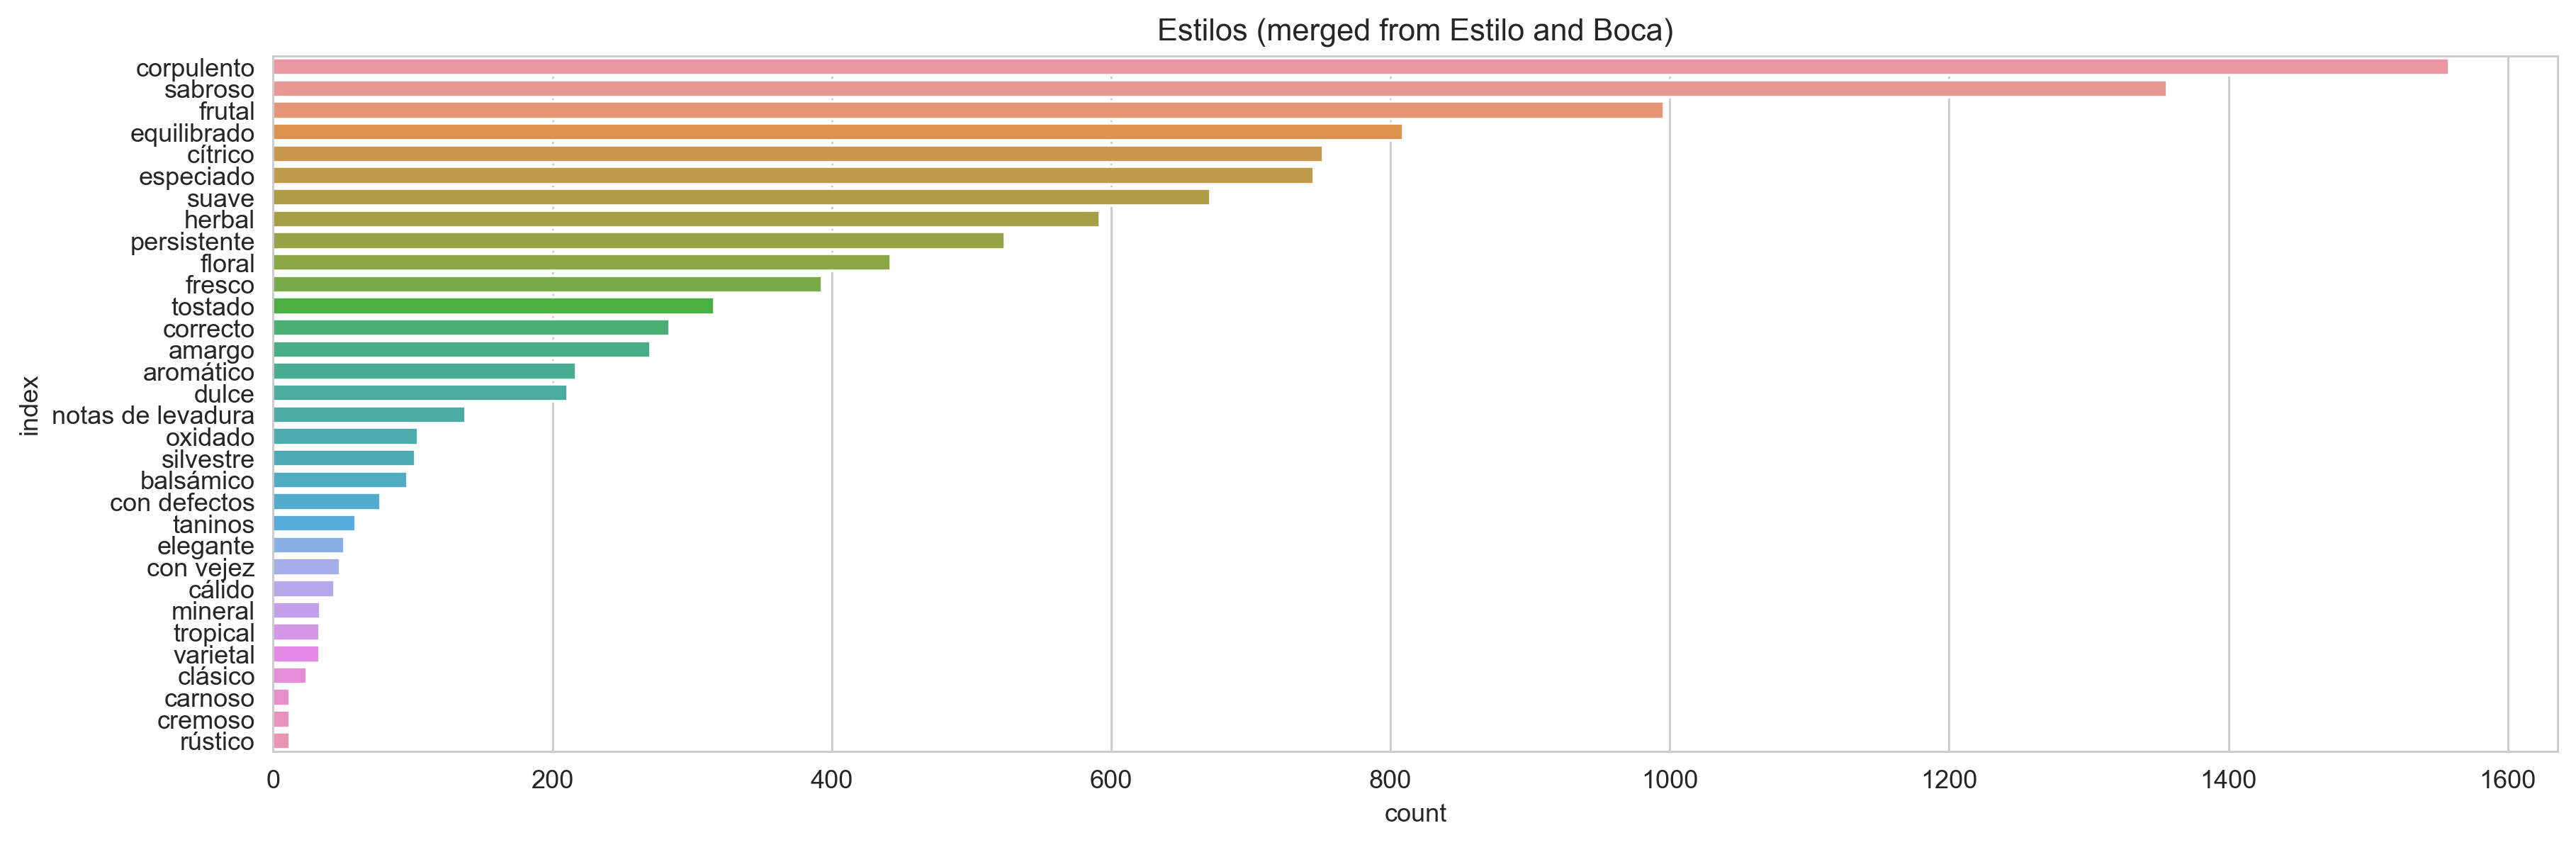

In [55]:
n_start_new_estilo2,n_end_new_estilo2,all_feat_new_estilo2 = barplot_wine_aspect(df.new_estilo2, 'Estilos (merged from Estilo and Boca)',100,save_excel=False,plot=False)
n_start_new_estilo2,n_end_new_estilo2,feat_new_estilo2 = barplot_wine_aspect(df.new_estilo2, 'Estilos (merged from Estilo and Boca)',100,save_excel=False,plot=True)

### Color

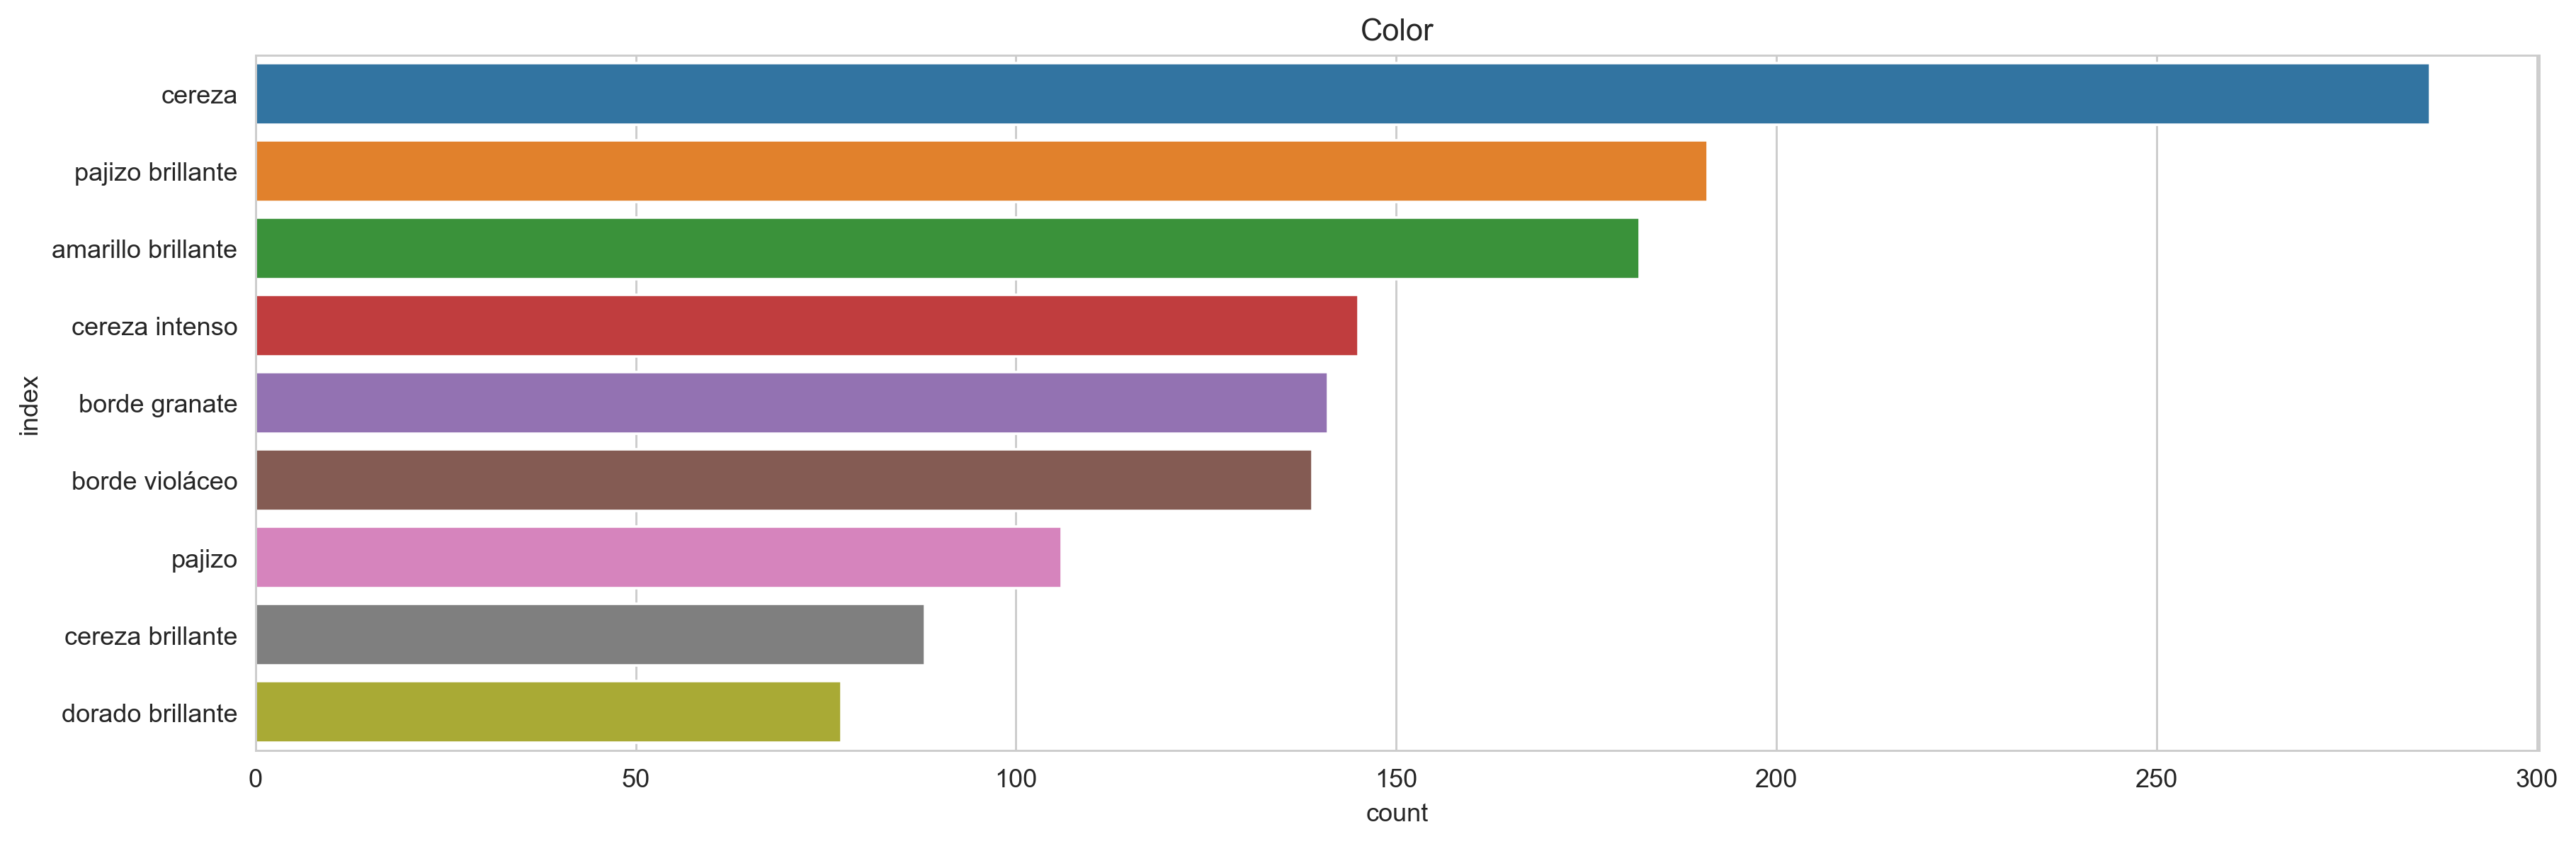

In [56]:
n_start_color,n_end_color,feat_color  = barplot_wine_aspect(df.color, 'Color', 85,plot=True)

In [57]:
print(f"We start having {n_start_color} colors that we have reduced up to {n_end_color}")

We start having 32 colors that we have reduced up to 9


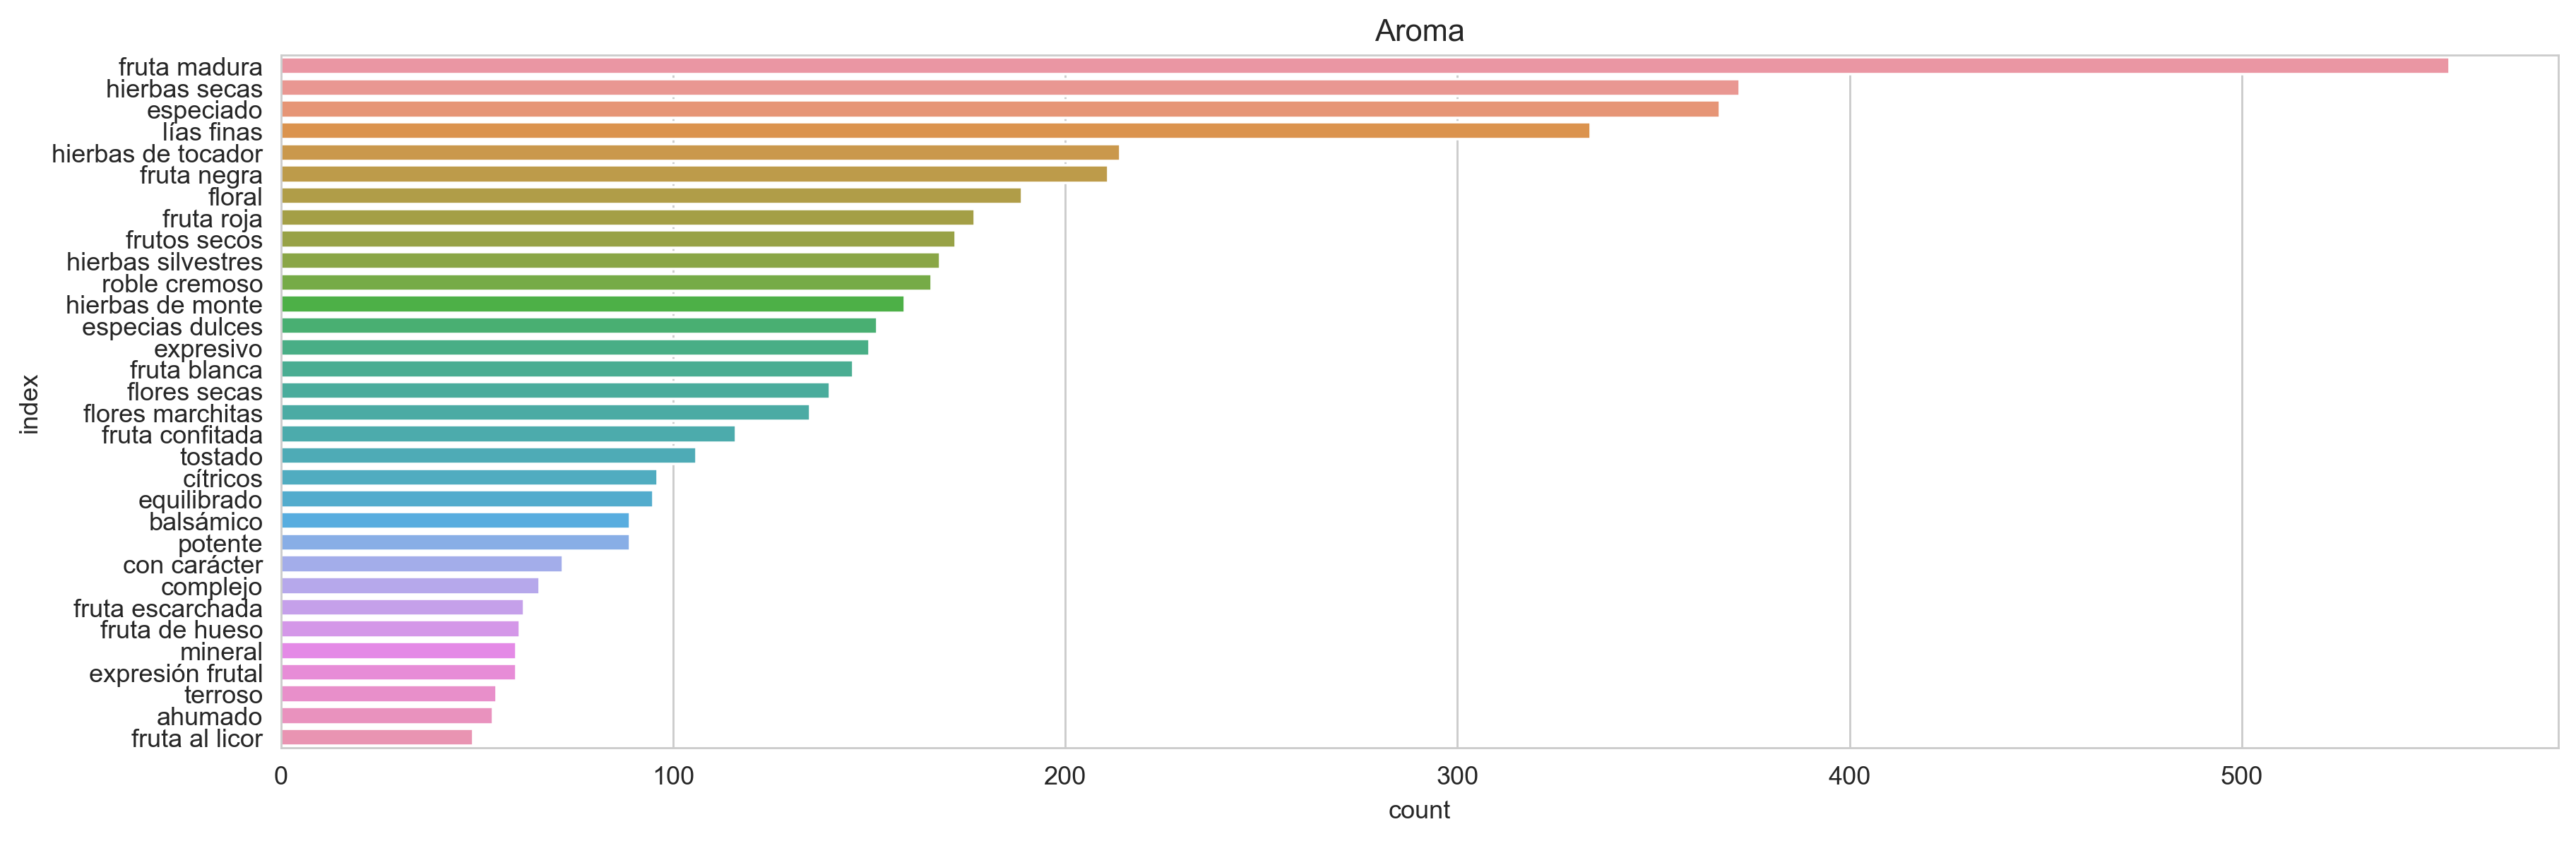

In [58]:
n_start_smell,n_end_smell,feat_aroma = barplot_wine_aspect(df.aroma, 'Aroma'  , 85,plot=True)

In [59]:
print(f"We start having {n_start_smell} smells that we have reduced up to {n_end_smell}")

We start having 104 smells that we have reduced up to 32


In [60]:
# Save the data before the OneHotEncodings for web visualitzation
df.to_excel("wine_web_data_style_processed.xlsx",index=False)

## Saving the cleaned data into files to be processed later one

In this section we will save the data in a structured manner that will facilitate the training of the different algorithms. We want to basically train two algorithms:
- **Recommend most similar wines**: Content Based Recommender that will use most of the analyzed attributes in order to predict most similar wines given a specific wine selected by the user.
- **Predict DO based on type and style**: Supervised learning algorithm that from Type (red,white,*rosé*,sparkling) and the style (fruty,aromatic,critic,...) will try to predict what DO could come from

### Recommend most similar wines

Let us create a one hot encoding for the categorical vairables:

In [61]:
import warnings
warnings.filterwarnings("ignore")

df2 = df.copy()
    
create_onehot_encoding(df2, df2.tipo, feat_tipos) 
create_onehot_encoding(df2, df2.tipo_simplified, feat_tipo) # get only if the wine is red,white or sparkling
create_onehot_encoding(df2, df2.variedades, feat_variedades)
create_onehot_encoding(df2, df2.aroma, feat_aroma)
create_onehot_encoding(df2, df2.color, feat_color)
create_onehot_encoding(df2, df2.new_estilo2, all_feat_new_estilo2) # get all tipos
create_onehot_encoding(df2, df2["zona de producción"], feat_zona)


# We select all years
feat_year = df2.year.unique()
feat_year = [x for x in feat_year if x == x] # remove nan from a year
create_onehot_encoding(df2, df2.year, feat_year)



# defrag
df2 = df2.copy()
df2.ecologic = df2.ecologic.astype(int)

When recommending wines based on its content we'll only use the following attributes:

In [76]:
len(feat_year)

19

In [63]:
# Columns that will be used to recommend most similar wines
columns = [
    'id','name_no_year', 'price', 'points'
] + list(feat_tipos) + list(feat_tipo) + list(feat_variedades) + list(all_feat_new_estilo2) + list(feat_aroma) + list(feat_color) + list(feat_zona) + list(feat_year) + ["ecologic"]

columns_tipo_simple = [
    'id','name_no_year', 
] + list(feat_tipo) + list(all_feat_new_estilo2) + list(feat_aroma) + list(feat_color) + list(feat_zona)



# remove duplicates
columns = list(dict.fromkeys(columns))
columns_tipo_simple = list(dict.fromkeys(columns_tipo_simple))

# DataFrame that contains only this columns
df3 = df2[columns].copy()

We see that some descriptors appear both in *aroma* and *estilo*. 

For example *floral*:

In [64]:
print("floral" in feat_estilo)
print("floral" in feat_aroma)


True
True


Let's sum all the repeated columns:

In [65]:
print (len(df3.columns))
df3 = df3.groupby(level=0, axis=1).max()
print (len(df3.columns))

148
148


We can see that we started with 132 different columns and we ended up with only 117.

Let's save it into an Excel file for latter processing

In [66]:
#saving it to an excel file
df3[columns].to_excel('CBR_OneHot.xlsx',index=False)
df3[columns_tipo_simple].to_excel('CBRDO_OneHot.xlsx',index=False)

### Predict DO from type and style
Supervised learning algorithm that from Type (red,white,*rosé*,sparkling) and the style (fruty,aromatic,critic,...) will try to predict what DO could come from

In [67]:
df5 = df2.copy()
df5["not_nulls"] = df5[["tipo_simplified","new_estilo2","variedades","zona de producción"]].notnull().apply(np.prod, axis=1)

# Same trick than previously
df5 = df5.groupby(level=0, axis=1).max()

In [68]:
# Save X and Y vector seperately 
Xcolumns = list(feat_tipo)  + list(all_feat_new_estilo2)
yvaridedad = list(feat_variedades)
yzona = list(feat_zona)

df5[df5["not_nulls"]==1][Xcolumns].to_csv("X_pred_do_variedad.csv",index=False)
df5[df5["not_nulls"]==1][yvaridedad].to_csv("y_pred_variedad.csv",index=False)
df5[df5["not_nulls"]==1][yzona].to_csv("y_pred_do.csv",index=False)